# Прогнозирование потребления электроэнергии металлургического предприятия на этапе обработки стали 

**ОПИСАНИЕ ЗАДАЧИ:** 

Для оптимизации производственных расходов металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Необходимо построить модель, которая предскажет температуру стали.

**ПЛАН РАБОТЫ:**

1.	Описание проекта, задачи
2.	Изучение и подготовка данных.
3.	Предобработка данных
4.	Подготовка данных:  
    - Формирование итоговых датафреймов
    - Формирование целевого и остальных признаков
    - Формирование обучающих и тестовых выборок
5.	Обучение моделей
6.	Тестирование моделей
7.  ВЫВОД


**ОПИСАНИЕ ДАННЫХ:**


Данные состоят из файлов, полученных из разных источников:

- data_arc.csv — данные об электродах;
- data_bulk.csv — данные о подаче сыпучих материалов (объём);
- data_bulk_time.csv — данные о подаче сыпучих материалов (время);
- data_gas.csv — данные о продувке сплава газом;
- data_temp.csv — результаты измерения температуры;
- data_wire.csv — данные о проволочных материалах (объём);
- data_wire_time.csv — данные о проволочных материалах (время).

Во всех файлах столбец key содержит номер партии. В файлах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.

### Импорт библиотек

In [1]:
!pip install skimpy

     |████████████████████████████████| 237 kB 2.2 MB/s eta 0:00:01
     |████████████████████████████████| 17.3 MB 22.8 MB/s eta 0:00:01
     |████████████████████████████████| 12.2 MB 73.5 MB/s eta 0:00:01
     |████████████████████████████████| 149 kB 85.3 MB/s eta 0:00:01
     |████████████████████████████████| 1.1 MB 42.1 MB/s eta 0:00:01
     |████████████████████████████████| 280 kB 66.9 MB/s eta 0:00:01
     |████████████████████████████████| 117 kB 87.8 MB/s eta 0:00:01
     |████████████████████████████████| 3.1 MB 53.9 MB/s eta 0:00:01
     |████████████████████████████████| 93 kB 477 kB/s  eta 0:00:01
     |████████████████████████████████| 51 kB 2.3 MB/s  eta 0:00:01
  Attempting uninstall: traitlets
    Found existing installation: traitlets 5.0.5
    Uninstalling traitlets-5.0.5:
      Successfully uninstalled traitlets-5.0.5
  Attempting uninstall: jupyter-core
    Found existing installation: jupyter-core 4.7.1
    Uninstalling jupyter-core-4.7.1:
      Successfully un

In [2]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

import sklearn as sk
import catboost as ct

from sklearn import tree
from sklearn import ensemble
from sklearn import linear_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.pipeline import make_pipeline
from catboost import CatBoostRegressor
from catboost import Pool

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.datasets import make_regression
from sklearn.dummy import DummyRegressor

from skimpy import skim
from skimpy import clean_columns

RND = 130323

### Подготовка и анализ данных

In [3]:
try:
    arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
    bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
    bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
    gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
    temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
    wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
    wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')
except FileNotFoundError:
    arc = pd.read_csv('https://code.s3.yandex.net/datasets/final_steel/data_arc.csv')
    bulk = pd.read_csv('https://code.s3.yandex.net/datasets/final_steel/data_bulk.csv')
    bulk_time = pd.read_csv('https://code.s3.yandex.net/datasets/final_steel/data_bulk_time.csv')
    gas = pd.read_csv('https://code.s3.yandex.net/datasets/final_steel/data_gas.csv')
    temp = pd.read_csv('https://code.s3.yandex.net/datasets/final_steel/data_temp.csv')
    wire = pd.read_csv('https://code.s3.yandex.net/datasets/final_steel/data_wire.csv')
    wire_time = pd.read_csv('https://code.s3.yandex.net/datasets/final_steel/data_wire_time.csv')

In [4]:
def check_data(data):
    display(data.head(5))
    display(data.tail(5))
    print(data.info())
    print()
    print(data.describe())
    print()
    print('Кол-во дубликатов:', data.duplicated().sum())
    print()

**Данные об электродах**

In [5]:
check_data(arc)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
14871,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.533670,0.354439
14872,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.676604,0.523631
14873,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.733899,0.475654
14874,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.220694,0.145768
14875,3241,2019-09-01 04:34:47,2019-09-01 04:36:08,0.306580,0.196708


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB
None

                key  Активная мощность  Реактивная мощность
count  14876.000000       14876.000000         14876.000000
mean    1615.220422           0.670441             0.452592
std      934.571502           0.408159             5.878702
min        1.000000           0.030002          -715.504924
25%      806.000000           0.395297             0.290991
50%     1617.000000           0.555517             0.415962
75%     2429.000000           0.857034       

Видим в файле строки с одинаковыми значениями key, они соответствуют разным итерациям обработки. Посмотрим на распределение количества итераций

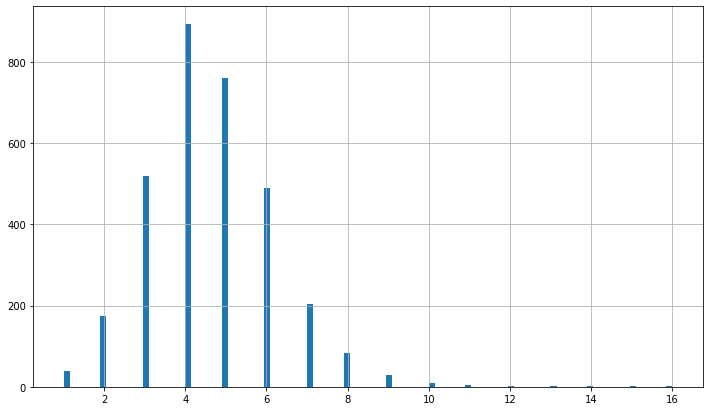

In [6]:
# гистограмма по столбцу Key
arc['key'].value_counts().hist(bins=100, figsize=(12,7))
plt.show()

Количество итераций варьируется от 1 до 16 для каждой партии. Распределение близко к нормальному. Чаще всего используется от 3х до 6 итераций

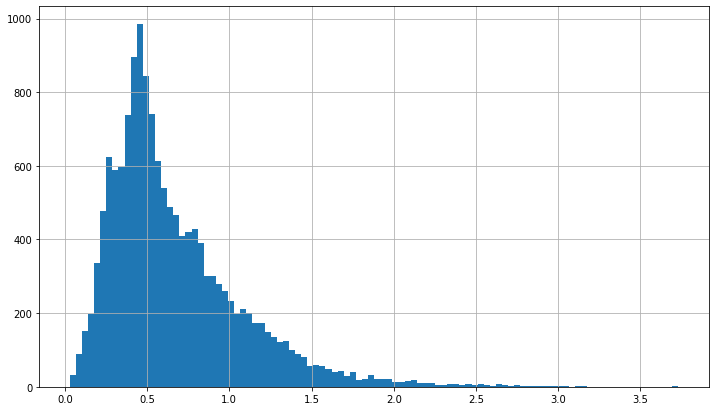

In [7]:
# Гистограмма по активной мощности
arc['Активная мощность'].hist(bins=100, figsize=(12,7))
plt.show()

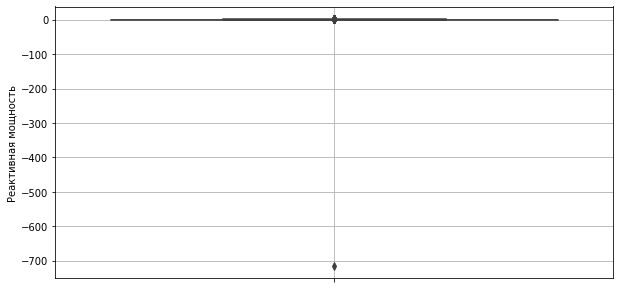

In [8]:
# Распределение реактивной мощности 
plt.figure(figsize=(10, 5))
sns.boxplot(y=arc['Реактивная мощность']) 
plt.grid()
plt.show()

В датафрейме data_arc 14876 строк, пропусков, дубликатов нет. Есть выброс в признаке Реактивная мощность со значением -715.504924

**Данные о подаче сыпучих материалов (объём)**


In [9]:
check_data(bulk)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
3124,3237,NaN,NaN,170.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,NaN,130.0,206.0
3125,3238,NaN,NaN,126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.0,NaN,108.0,106.0
3126,3239,NaN,NaN,NaN,NaN,NaN,114.0,NaN,NaN,NaN,NaN,NaN,158.0,NaN,270.0,88.0
3127,3240,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,54.0
3128,3241,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,180.0,52.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB
None

               key      Bulk 1      Bulk 2       Bulk 3       Bulk 4  \
count  3129.000000  252.000000   22.000000  1298.000000  1014.000000   
mean  

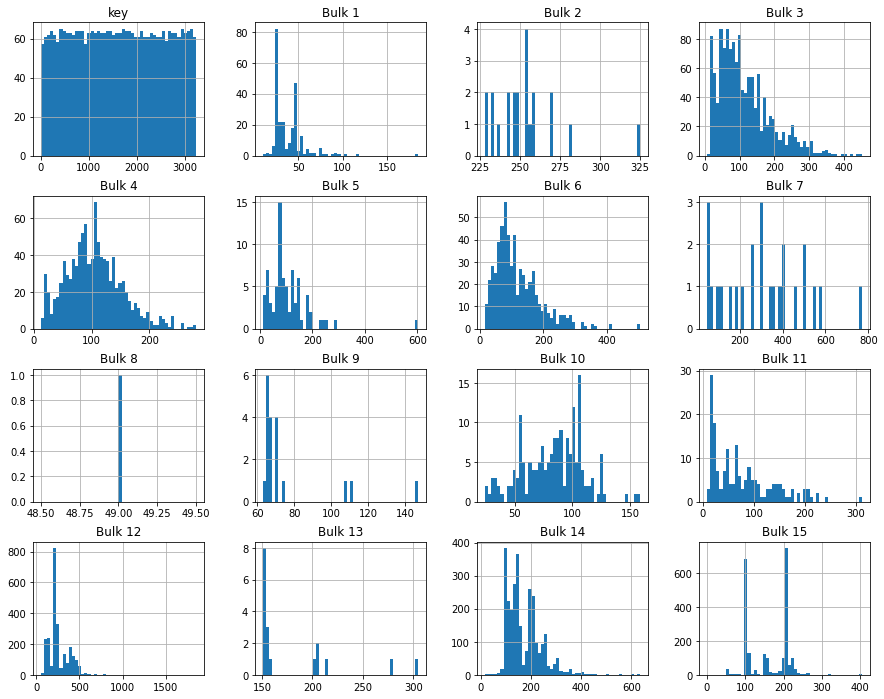

In [10]:
# гистограмма 
bulk.hist(bins=50, figsize=(15,12))
plt.show()

По гистограммам видно, что сыпучие материалы добавляются в разных объемах и в разных партиях используются разные материалы

In [11]:
len(bulk['key'].unique())

3129

**Данные о подаче сыпучих материалов (время)**

In [12]:
check_data(bulk_time)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
3124,3237,NaN,NaN,2019-08-31 22:51:28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-31 22:46:52,NaN,2019-08-31 22:46:52,2019-08-31 22:46:52
3125,3238,NaN,NaN,2019-08-31 23:39:11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-31 23:33:09,NaN,2019-08-31 23:33:09,2019-08-31 23:33:09
3126,3239,NaN,NaN,NaN,NaN,NaN,2019-09-01 01:51:58,NaN,NaN,NaN,NaN,NaN,2019-09-01 01:39:41,NaN,2019-09-01 01:33:25,2019-09-01 01:33:25
3127,3240,NaN,NaN,NaN,NaN,NaN,2019-09-01 03:12:40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-01 02:41:27,2019-09-01 02:41:27
3128,3241,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-01 04:05:34,2019-09-01 04:05:34


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB
None

               key
count  3129.000000
mean   1624.383509
std     933.337642
min       1.000000
25%     816.000000
50%    1622.000000
75%    2431.000000
max    3241.0000

In [13]:
len(bulk_time['key'].unique())

3129

В данных о подаче сыпучих материалов по объему и времени 16 признаков, очень много пропусков, скорее всего, это обусловлено спецификой технологического процесса, видимо, это просто отсутствие засыпки на определенном этапе. 3129 уникальных номеров партий, каждому значению соответствует одна строка. Дубликатов нет

**Данные о продувке сплава газом**

In [14]:
check_data(gas)

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


,key,Газ 1
3234,3237,5.543905
3235,3238,6.745669
3236,3239,16.023518
3237,3240,11.863103
3238,3241,12.680959


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB
None

               key        Газ 1
count  3239.000000  3239.000000
mean   1621.861377    11.002062
std     935.386334     6.220327
min       1.000000     0.008399
25%     812.500000     7.043089
50%    1622.000000     9.836267
75%    2431.500000    13.769915
max    3241.000000    77.995040

Кол-во дубликатов: 0



In [15]:
len(gas['key'].unique())

3239

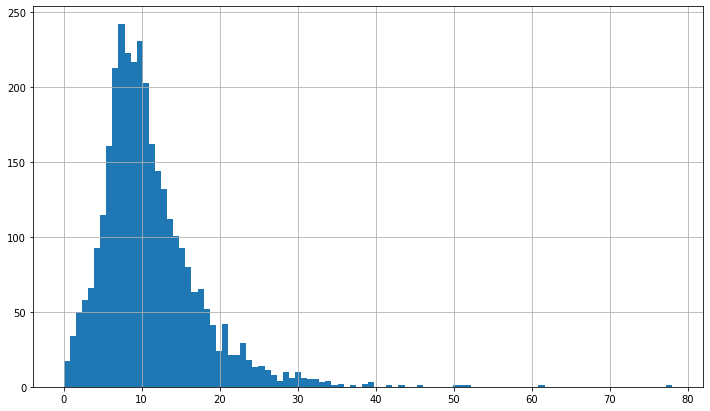

In [16]:
# гистограмма по столбцу Газ1
gas['Газ 1'].hist(bins=100, figsize=(12,7))
plt.show()

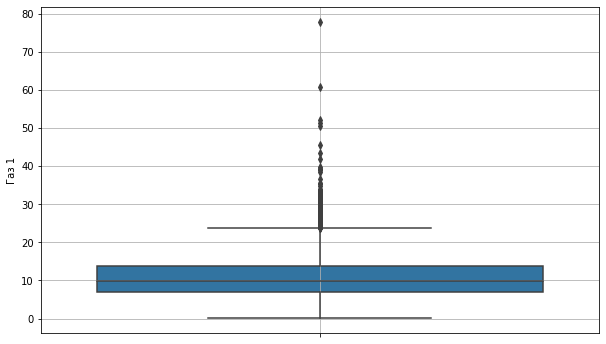

In [17]:
plt.figure(figsize=(10,6))
sns.boxplot(y=gas['Газ 1'])
plt.grid(True)
plt.show()

В датафрейме gas 3239 строк, 1 признак, пропусков и дубликатов нет.  

**Результаты измерения температуры**

In [18]:
check_data(temp)

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


,key,Время замера,Температура
15902,3241,2019-09-01 04:03:30,1586.0
15903,3241,2019-09-01 04:16:12,NaN
15904,3241,2019-09-01 04:22:39,NaN
15905,3241,2019-09-01 04:33:42,NaN
15906,3241,2019-09-01 04:38:08,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB
None

                key   Температура
count  15907.000000  13006.000000
mean    1607.880870   1591.840920
std      942.212073     21.375851
min        1.000000   1191.000000
25%      790.000000   1581.000000
50%     1618.000000   1591.000000
75%     2427.000000   1601.000000
max     3241.000000   1705.000000

Кол-во дубликатов: 0



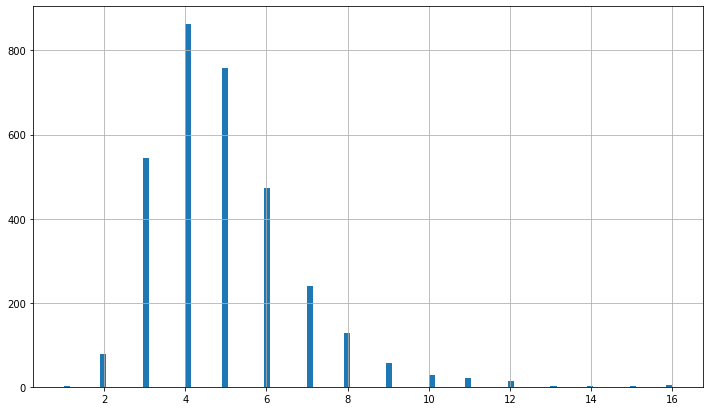

In [19]:
# гистограмма по столбцу key
temp['key'].value_counts().hist(bins=100, figsize=(12,7))
plt.show()

Количество итераций варьируется от 1 до 16 для каждой партии. По некоторым партиям было несколько замеров, в некоторых строках температура не заполнена, есть пропуски

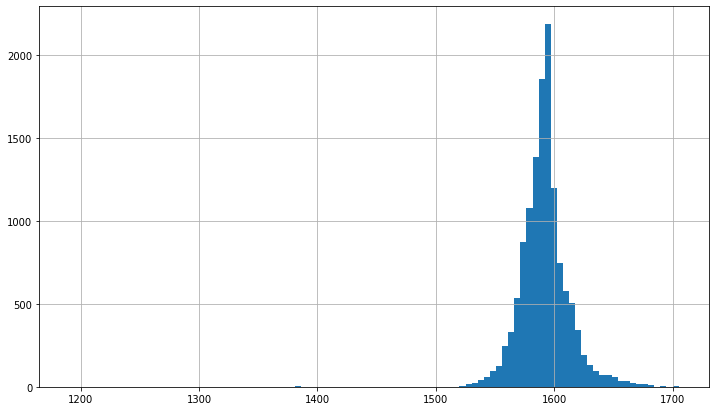

In [20]:
# Посмотрим на график температуры
temp['Температура'].hist(bins=100, figsize=(12,7))
plt.show()

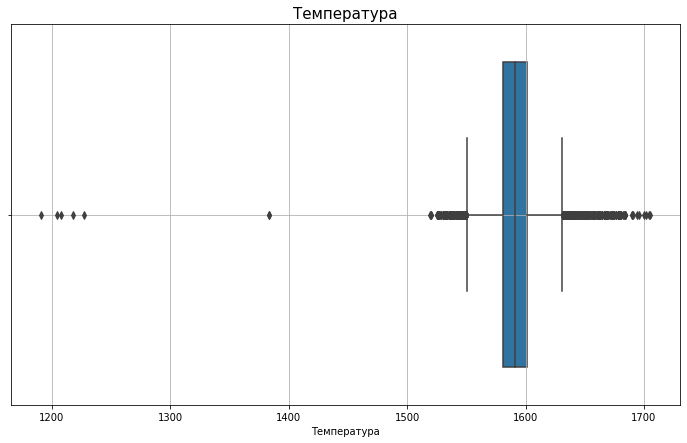

In [21]:
plt.figure(figsize=(12,7))
sns.boxplot(temp['Температура'])
plt.title('Температура', fontsize=15)
plt.grid(True)
plt.show()

Присутствуют выбросы в диапазонах до 1400 и после 1680. Температура плавления стали ~ 1550 градусов

**Данные о проволочных материалах (объём)**

In [22]:
check_data(wire)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
3076,3237,38.088959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,56.128799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,143.357761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,34.070400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3080,3241,63.117595,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB
None

               key       Wire 1       Wire 2      Wire 3      Wire 4  Wire 5  \
count  3081.000000  3055.000000  1079.000000   63.000000   14.000000   1.000   
mean   1623.426485   100.895853    50.577323  189.482681   57.442841  15.132   
std     932.996726    42.012518    39.320216   99.513444   28.824667     NaN   
min       1.000000     1.918800     0.030160    0.144144   24.148801  1

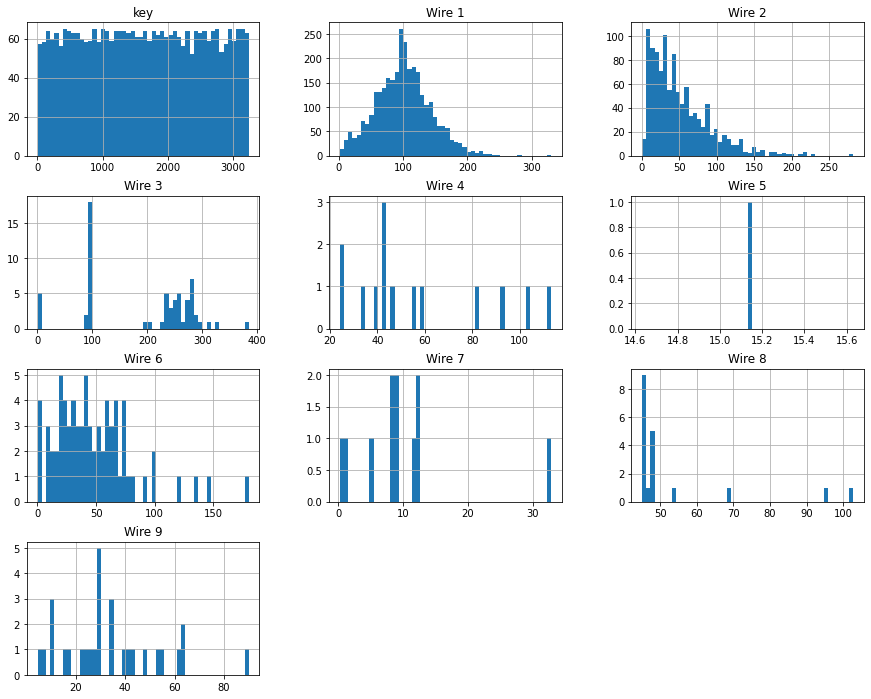

In [23]:
# гистограмма 
wire.hist(bins=50, figsize=(15,12))
plt.show()

Аналогично сыпучим материалам, по гистограммам видно, что проволока добавляется в разных объемах и в разных партиях используются разные материалы.

In [24]:
temp.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


**Данные о проволочных материалах (время)**

In [25]:
check_data(wire_time)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
3076,3237,2019-08-31 22:50:20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,2019-08-31 23:38:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,2019-09-01 01:50:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,2019-09-01 03:12:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3080,3241,2019-09-01 04:16:01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB
None

               key
count  3081.000000
mean   1623.426485
std     932.996726
min       1.000000
25%     823.000000
50%    1619.000000
75%    2434.000000
max    3241.000000

Кол-во дубликатов: 0



Аналогично подаче сыпучих материалов, очень много пропусков, скорее всего, это обусловлено спецификой технологического процесса. 3081 уникальных номеров партий, каждому значению соответствует одна строка. Дубликатов нет

**ВЫВОДЫ ПО ИЗУЧЕНИЮ ДАННЫХ:**



- Столбцы на разных языках. Имена столбцов нужно превести к общепринятому "змеиному" виду (английским языком, прописными буквами и без пробелов).

- Во всех данных необходим перевод времени в формат datetime. 

- Количество пропусков в столбцах по данным об объёмах и времени подачи материалов совпадают.

- Количество уникальных key, номеров партии, в таблицах разное:  
    3241 в data_arc  
    3129 в data_bulk и data_bulk_time  
    3239 в data_gas  
    3081 в data_wire и data_wire_time

- На каждую партию может быть несколько замеров температуры и несколько данных об электродах на разные моменты времени.

- Целевым признаком будет последний замер температуры в датасете temp 

- Необходимо разобраться с пропусками, выяснить их природу, причинами могут быть, например: особенность технологического производства, ошибка переноса, ошибка датчика, просто остутсвие необходимости в проведении действия (нагрев, добавка присадок и пр.)

- Объединить датасеты в один по столбцу key

- Добавить новые признаки

### Предобработка

#### Изменение типов данных и названий столбцов

Приведем названия столбцов к "змеиному регистру"

In [26]:
arc = arc.rename(columns={'Начало нагрева дугой': 'start_heating', 'Конец нагрева дугой': 'end_heating',
                         'Активная мощность': 'active_power', 'Реактивная мощность': 'reactive_power'})
gas = gas.rename(columns={'Газ 1': 'gas_1'})
temp = temp.rename(columns={'Время замера': 'measure_time','Температура': 'temperature'})

In [27]:
bulk = clean_columns(bulk)
bulk_time = clean_columns(bulk_time)
wire = clean_columns(wire)
wire_time = clean_columns(wire_time)


15 column names have been cleaned

15 column names have been cleaned

9 column names have been cleaned

9 column names have been cleaned

Проверим, что получилось

In [28]:
arc.head()

,key,start_heating,end_heating,active_power,reactive_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


In [29]:
gas.head(3)

,key,gas_1
0,1,29.749986
1,2,12.555561
2,3,28.554793


In [30]:
temp.head(3)

,key,measure_time,temperature
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0


In [31]:
bulk.head(3)

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0


In [32]:
wire.head(3)

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Приведём все столбцы, содержащие время, к типу datetime

In [33]:
arc['start_heating'] = pd.to_datetime(arc['start_heating'], format='%Y-%m-%d %H:%M:%S')
arc['end_heating'] = pd.to_datetime(arc['end_heating'], format='%Y-%m-%d %H:%M:%S')
temp['measure_time'] = pd.to_datetime(temp['measure_time'], format='%Y-%m-%d %H:%M:%S')

bulk_time.iloc[1:] = bulk_time.iloc[1:].apply(pd.to_datetime, format='%Y-%m-%d %H:%M:%S', errors='coerce')
wire_time.iloc[1:] = wire_time.iloc[1:].apply(pd.to_datetime, format='%Y-%m-%d %H:%M:%S', errors='coerce')

####  Работа с пропусками и выбросами

Проверим, какая доля заполенных данных по каждому столбцу в данных о добавках

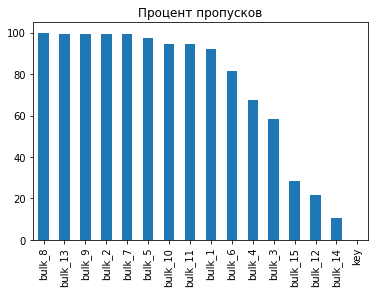

In [34]:
(bulk.isna().sum().sort_values(ascending=False) / bulk.shape[0] * 100).plot(kind='bar', 
                                                                            title = 'Процент пропусков')
plt.show()

In [35]:
bulk.apply(lambda x: f"{(x.count()/len(x))*100:.2f}%")

key        100.00%
bulk_1       8.05%
bulk_2       0.70%
bulk_3      41.48%
bulk_4      32.41%
bulk_5       2.46%
bulk_6      18.41%
bulk_7       0.80%
bulk_8       0.03%
bulk_9       0.61%
bulk_10      5.62%
bulk_11      5.66%
bulk_12     78.30%
bulk_13      0.58%
bulk_14     89.68%
bulk_15     71.84%
dtype: object

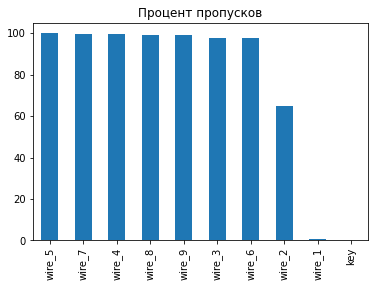

In [36]:
(wire.isna().sum().sort_values(ascending=False) / wire.shape[0] * 100).plot(kind='bar', 
                                                                          title = 'Процент пропусков')
plt.show()

In [37]:
wire.apply(lambda x: f"{(x.count()/len(x))*100:.2f}%")

key       100.00%
wire_1     99.16%
wire_2     35.02%
wire_3      2.04%
wire_4      0.45%
wire_5      0.03%
wire_6      2.37%
wire_7      0.36%
wire_8      0.62%
wire_9      0.94%
dtype: object

Заменим пропуски на нули исходя из предположения, что пропуск показывает отсутствие добавление материала

In [38]:
bulk = bulk.fillna(0)
bulk_time = bulk_time.fillna(0)
wire = wire.fillna(0)
wire_time = wire_time.fillna(0)

Удалим столбцы bulk_8 и wire_5, так как в них не содержится никакой информации

In [39]:
bulk = bulk.drop('bulk_8', axis=1)
wire = wire.drop('wire_5', axis=1)

Проверим какие столбцы у нас остались

In [40]:
bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 15 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   bulk_1   3129 non-null   float64
 2   bulk_2   3129 non-null   float64
 3   bulk_3   3129 non-null   float64
 4   bulk_4   3129 non-null   float64
 5   bulk_5   3129 non-null   float64
 6   bulk_6   3129 non-null   float64
 7   bulk_7   3129 non-null   float64
 8   bulk_9   3129 non-null   float64
 9   bulk_10  3129 non-null   float64
 10  bulk_11  3129 non-null   float64
 11  bulk_12  3129 non-null   float64
 12  bulk_13  3129 non-null   float64
 13  bulk_14  3129 non-null   float64
 14  bulk_15  3129 non-null   float64
dtypes: float64(14), int64(1)
memory usage: 366.8 KB


In [41]:
wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   wire_1  3081 non-null   float64
 2   wire_2  3081 non-null   float64
 3   wire_3  3081 non-null   float64
 4   wire_4  3081 non-null   float64
 5   wire_6  3081 non-null   float64
 6   wire_7  3081 non-null   float64
 7   wire_8  3081 non-null   float64
 8   wire_9  3081 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 216.8 KB


Избавимся от данных с пропусками по замерам температуры. Конечная температура является целевым признаком, но если целевой признак NaN, то мы не сможем работать с такими данными

In [42]:
temp = temp.dropna()

По каждой партии должно минимум 2 замера; если был произведен только 1 замер, то данные о таких партиях мы не сможем использовать по условию задачи

In [43]:
temp = temp[temp['key'].isin(temp['key'].value_counts()[temp['key'].value_counts()>1].index)] 
temp.shape

(12265, 3)

Удалим все строки с партиями, где значения температуры меньше 1400. Температура плавления, согласно справочным данным, может считаться реальной при значениях выше 1400 градусов

In [44]:
#удалим все строки с партиями, где температура < 1400
key_1400 = temp[temp['temperature'] < 1400]['key'].unique()
temp = temp[~temp['key'].isin(key_1400)]
temp = temp.reset_index(drop=True)
temp

,key,measure_time,temperature
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
...,...,...,...
12216,2498,2019-08-06 02:19:26,1593.0
12217,2498,2019-08-06 02:25:31,1594.0
12218,2499,2019-08-06 02:40:25,1569.0
12219,2499,2019-08-06 02:54:24,1604.0


Посмотрим, сколько в даных строк с отрицательными значениями реактивной мощности. Отрицательные значения в данном случае будут выбросами

In [45]:
arc[arc['reactive_power'] <= 0]

,key,start_heating,end_heating,active_power,reactive_power
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924


In [46]:
# уберем выброс
arc = arc[arc['reactive_power'] > 0]

#### Выделение начальной и конечной температуры

По условию задачи целевым признаком является конечная температура; промежуточные значения между начальной и конечной мы не учитываем

In [49]:
temp_first = pd.merge(temp.groupby('key')['measure_time'].agg('min'), temp, how='left', on='measure_time')
temp_last = pd.merge(temp.groupby('key')['measure_time'].agg('max'), temp, how='left', on='measure_time')
temp_new = pd.merge(temp_first[['key','temperature']], temp_last[['key','temperature']],
                    how='outer', on='key')
temp_new = temp_new.rename(columns={'temperature_x': 'temperature_first',
                                    'temperature_y': 'temperature_last'})

Посчитаем время между замерами температуры

In [50]:
temp_new = pd.merge(temp_new, temp[['key','measure_time']].groupby('key')['measure_time'].
              agg(lambda x: x.max()-x.min()).dt.total_seconds(), how='left', on='key')
temp_new

,key,temperature_first,temperature_last,measure_time
0,1,1571.0,1613.0,861.0
1,2,1581.0,1602.0,1305.0
2,3,1596.0,1599.0,1300.0
3,4,1601.0,1625.0,388.0
4,5,1576.0,1602.0,762.0
...,...,...,...,...
2465,2495,1570.0,1591.0,1137.0
2466,2496,1554.0,1591.0,1618.0
2467,2497,1571.0,1589.0,717.0
2468,2498,1591.0,1594.0,1302.0


#### Расчёт суммарного времени нагрева

Вычисляем время нагрева электродами по всем промежуткам для arc (в секундах)

In [51]:
arc['heating_time'] = (arc['end_heating'] - arc['start_heating']).dt.seconds

In [52]:
arc['heating_time'].describe()

count    14875.000000
mean       171.675160
std         98.188759
min         11.000000
25%        107.000000
50%        147.000000
75%        214.000000
max        907.000000
Name: heating_time, dtype: float64

#### Добавление данных 

Добавим столбец с данными о полной мощности. Полная мощность рассчитывается по формуле:
$$
S = \sqrt { P ^ 2+Q ^ 2 }
$$

In [53]:
arc['power'] = np.sqrt(arc['active_power']**2 + arc['reactive_power']**2)

Также найдем A_total - итоговую работу, которая вычисляется по формуле:  
$$
A = S * t
$$

In [54]:
arc['work'] = arc['heating_time'] * arc['power']

arc

,key,start_heating,end_heating,active_power,reactive_power,heating_time,power,work
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,228,1.193639,272.149755
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,185,0.959010,177.416785
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,172,0.896038,154.118502
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,365,1.970470,719.221394
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,148,0.807239,119.471318
...,...,...,...,...,...,...,...,...
14871,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.533670,0.354439,157,0.640648,100.581755
14872,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.676604,0.523631,180,0.855559,154.000682
14873,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.733899,0.475654,184,0.874560,160.919002
14874,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.220694,0.145768,57,0.264489,15.075853


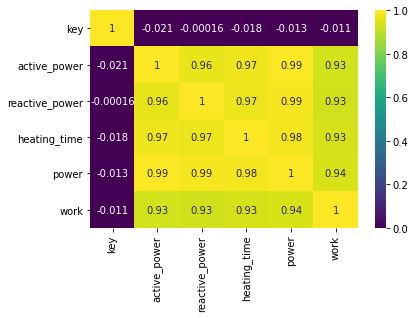

In [55]:
#корреляция
sns.heatmap(arc.corr(), cmap='viridis', annot=True, vmin=0);

Наблюдаем ожидаемо высокую корреляцию между признаками. Для дальнейшей работы оставим только признак "работа"

In [56]:
arc = arc.groupby('key').agg({'work': sum})
arc

,work
key,
1,1442.377754
2,881.233565
3,525.066777
4,796.911309
5,1199.137958
...,...
3237,958.336236
3238,555.867370
3239,1013.067719


#### Объединение таблиц в единый датафрейм

In [57]:
df = temp_new.merge(right=arc,
                       how='inner',
                       on='key')\
                .merge(right=bulk,
                       how='inner',
                       on='key')\
                .merge(right=gas,
                       how='inner',
                       on='key')\
                .merge(right=wire,
                       how='inner',
                       on='key')
df

,key,temperature_first,temperature_last,measure_time,work,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,...,bulk_15,gas_1,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9
0,1,1571.0,1613.0,861.0,1442.377754,0.0,0.0,0.0,43.0,0.0,...,154.0,29.749986,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
1,2,1581.0,1602.0,1305.0,881.233565,0.0,0.0,0.0,73.0,0.0,...,154.0,12.555561,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2,3,1596.0,1599.0,1300.0,525.066777,0.0,0.0,0.0,34.0,0.0,...,153.0,28.554793,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
3,4,1601.0,1625.0,388.0,796.911309,0.0,0.0,0.0,81.0,0.0,...,154.0,18.841219,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
4,5,1576.0,1602.0,762.0,1199.137958,0.0,0.0,0.0,78.0,0.0,...,152.0,5.413692,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2320,2495,1570.0,1591.0,1137.0,778.818234,0.0,0.0,21.0,0.0,0.0,...,223.0,7.125735,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2321,2496,1554.0,1591.0,1618.0,875.261419,0.0,0.0,0.0,63.0,0.0,...,226.0,9.412616,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2322,2497,1571.0,1589.0,717.0,556.930349,0.0,0.0,0.0,85.0,0.0,...,226.0,6.271699,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0
2323,2498,1591.0,1594.0,1302.0,767.817794,0.0,0.0,90.0,0.0,0.0,...,207.0,14.953657,118.110717,0.00000,0.0,0.0,0.0,0.0,0.0,0.0


Проверим объединенную таблицу на пропуски

In [58]:
df.isna().sum()

key                  0
temperature_first    0
temperature_last     0
measure_time         0
work                 0
bulk_1               0
bulk_2               0
bulk_3               0
bulk_4               0
bulk_5               0
bulk_6               0
bulk_7               0
bulk_9               0
bulk_10              0
bulk_11              0
bulk_12              0
bulk_13              0
bulk_14              0
bulk_15              0
gas_1                0
wire_1               0
wire_2               0
wire_3               0
wire_4               0
wire_6               0
wire_7               0
wire_8               0
wire_9               0
dtype: int64

Text(0.5, 1.0, 'Тепловая карта матрицы корреляций')

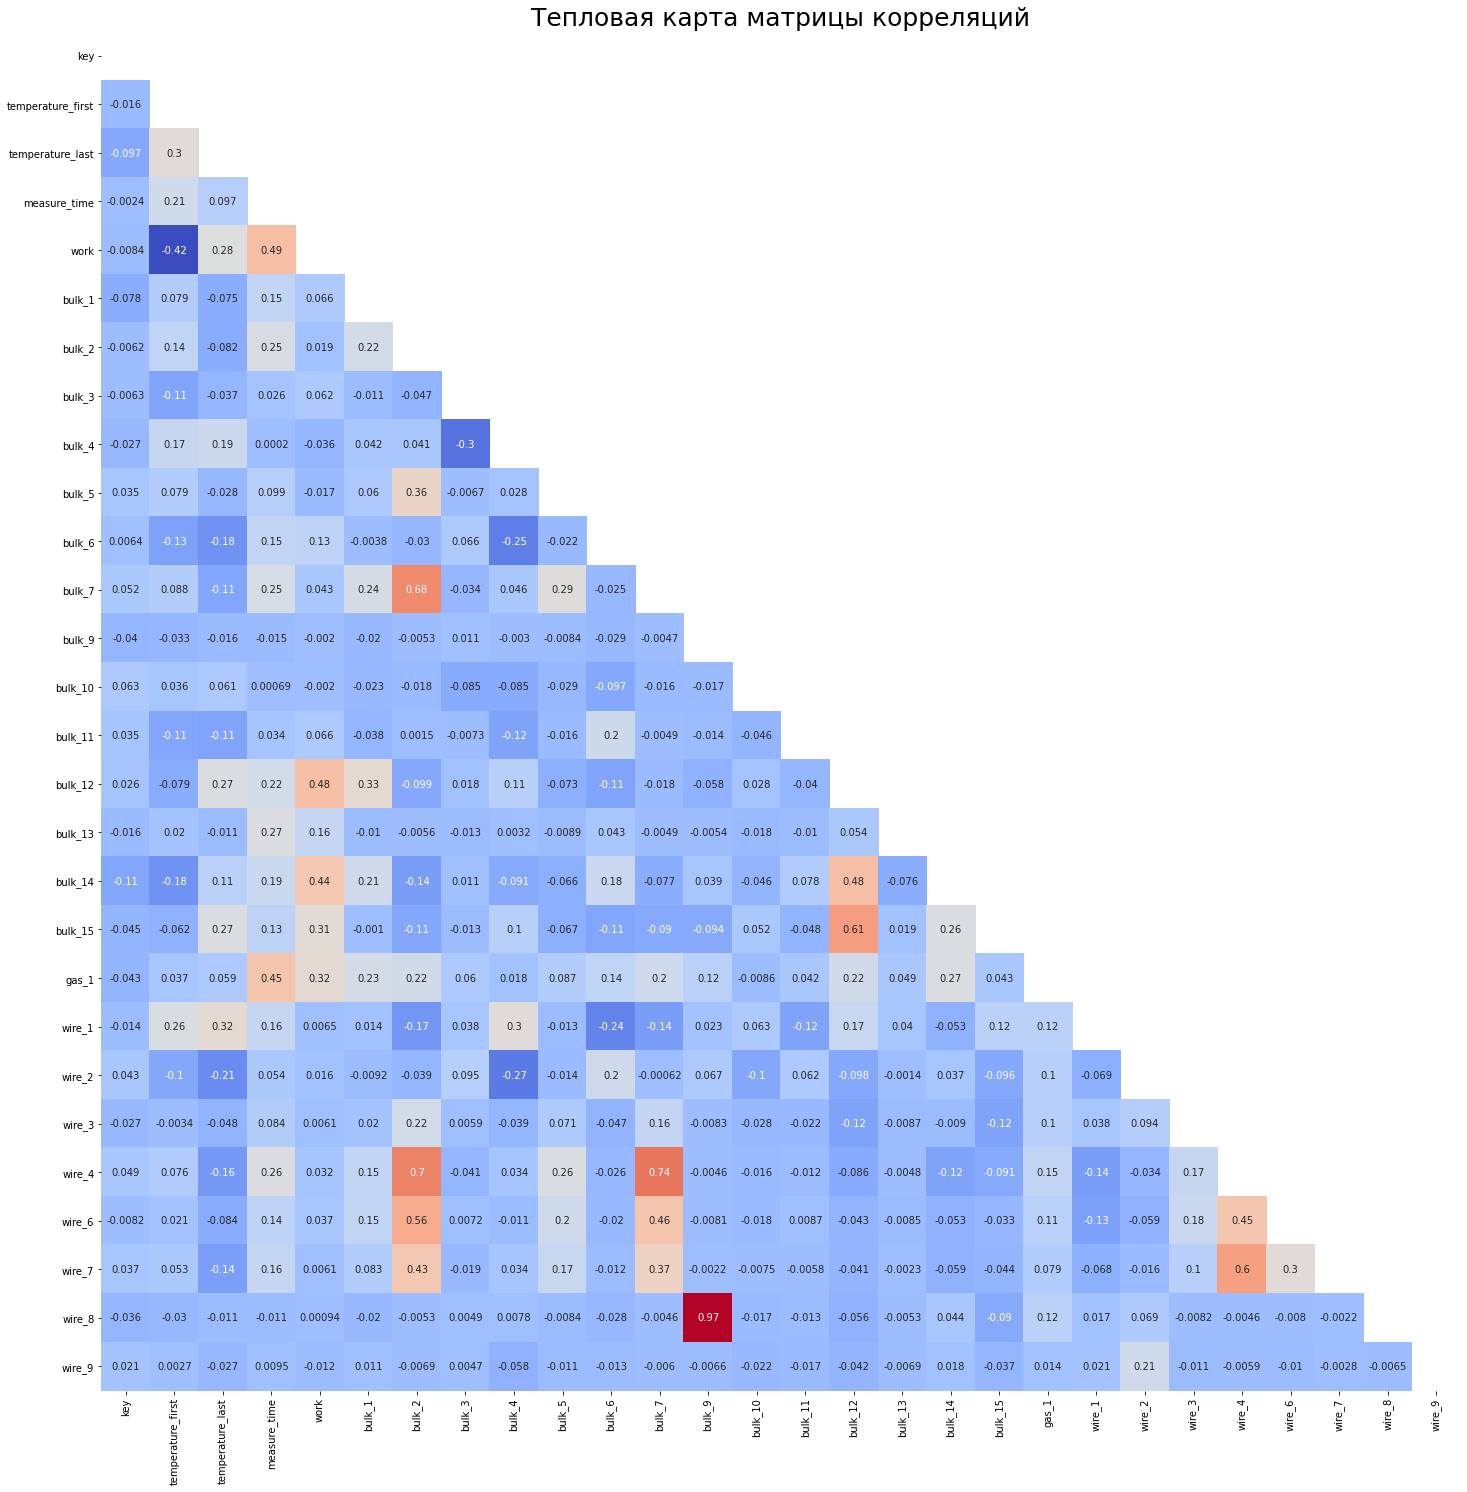

In [59]:
#тепловая карта корреляции
plt.figure(figsize=(25, 25))
matrix = np.triu(df.corr())
heatmap = sns.heatmap(df.corr(),
                      annot=True,
                      mask=matrix,
                      square=True,
                      cmap='coolwarm',
                      cbar=False,
                      fmt='.2g')
heatmap.set_title('Тепловая карта матрицы корреляций', fontsize=25)

In [60]:
df.corr()['temperature_last'].sort_values(ascending=False)[1:]

wire_1               0.317702
temperature_first    0.301961
work                 0.275000
bulk_12              0.267379
bulk_15              0.266386
bulk_4               0.188100
bulk_14              0.114520
measure_time         0.097425
bulk_10              0.061345
gas_1                0.059036
wire_8              -0.010772
bulk_13             -0.010925
bulk_9              -0.016081
wire_9              -0.027496
bulk_5              -0.028365
bulk_3              -0.036767
wire_3              -0.047548
bulk_1              -0.075233
bulk_2              -0.082466
wire_6              -0.084049
key                 -0.097052
bulk_7              -0.107289
bulk_11             -0.114777
wire_7              -0.137275
wire_4              -0.159737
bulk_6              -0.181880
wire_2              -0.206837
Name: temperature_last, dtype: float64

Целевой признак коррелирует сильнее, чем с другими, с:

- wire_1
- Температура в начале (ожидаемо)
- Работа (ожидаемо)
- bulk_12
- bulk_15

Зависимость умеренная прямопропорциональная.  
Обратная слабая зависимость  с wire_2, bulk_6, wire_4. 

Интересно, что есть очень высокая прямая зависимость между wire_8 и bulk_9 и высокая между wire_4 и bulk_2, wire_4 и bulk_7.

Удалим признак wire_8, так как очень высокая корреляция может привести к переобучению моделей

In [61]:
df = df.drop(['wire_8'], axis=1)

Построим график распределения и взаимной корреляции по выбранным параметрам


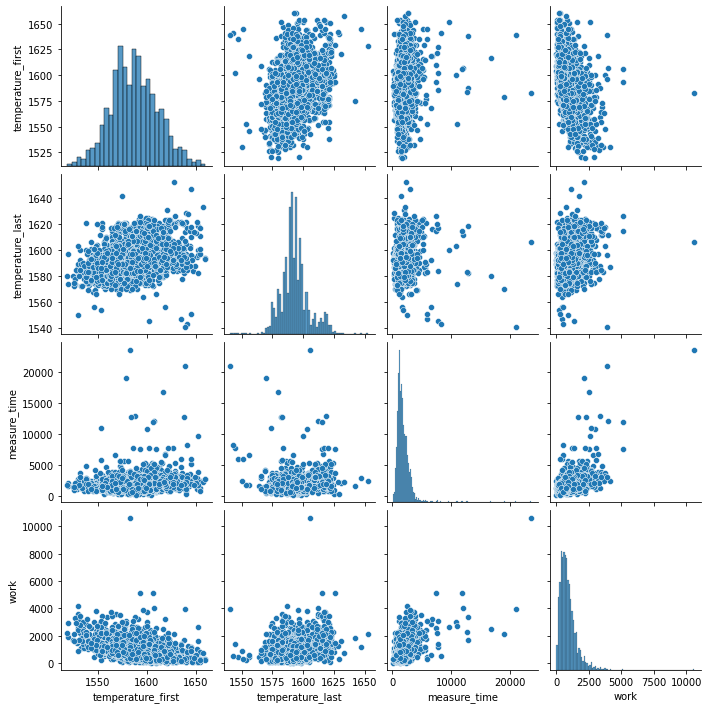

<Figure size 1440x1440 with 0 Axes>

In [62]:
sns.pairplot(df[[
    'temperature_first',
    'temperature_last',
    'measure_time',
    'work'
]])
plt.figure(figsize=(20,20))
plt.show()

Взаимной высокой корреляции не наблюдается

**ВЫВОДЫ:**

- Все датафреймы приведены к привычному "змеиному" регистру;
- Большое количество пропусков в данных по добавкам мы заменили на ноль, исходя из предположения, что пропуски показывают отсутствие добавление добавок;
- Стобцы bulk_8 и wire_5, в которых отсутствовала информация, мы удалили;
- Избавились от данных с пропусками по замерам температуры. По каждой партии должно минимум 2 замера; если был произведен только 1 замер, то данные о таких партиях мы не сможем использовать по условию задачи;
- Избавились от явных выбросов: значений температуры ниже 1400 градусов и значения реактивной мощности -715. Остальные отклонения мы оставляем, так как при определенных параметрах такие значения возможны и их удаление сделает модель рабочей только на ограниченном диапазоне парамеров;
- Выделили начальное и конечное значения температур, промежуточные значения мы не будем учитывать, так как целевым признаком является конечная температура; 
- Рассчитали время нагрева электродами по всем промежуткам для данных об электродах (в секундах);
- Добавили в данные об электродах рассчетные значения энергии, как произведения времени нагрева дугой и активной мощности. Так, как признаки в данных об электродах ( ожидаемо имеют очень высокую линейную зависимость, в итоговую таблицу добавили только рассчетные значения энергии.
- Удалили признак wire_8, так как очень высокая корреляция может привести к переобучению моделей
- Все таблицы объединены в единый датафрейм по номеру партии key

### Построение моделей


#### Подготовка данных для обучения модели

**Разделение на выборки**

In [63]:
# Удалим признак key как неинформативный
df = df.drop(['key'], axis = 1)

#разделим датасет на обучающую и тестовую выборки в соотношении 3:1

target = df['temperature_last']
features = df.drop('temperature_last', axis=1)

features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                            target, 
                                                                            test_size=0.25, 
                                                                            random_state=RND)

In [64]:
features_train.shape, features_test.shape, target_train.shape, target_test.shape

((1743, 25), (582, 25), (1743,), (582,))

По условию задачи выборки разделены в пропорции 3:1, random_state = 130323

#### Обучение и сравнение моделей по показателю MAE

**Линейная регрессия**

In [65]:
%%time

lr = make_pipeline(StandardScaler(), LinearRegression())
lr_params = {'linearregression__normalize':[False]}
grid = GridSearchCV(lr, param_grid=lr_params, scoring='neg_mean_absolute_error')
grid.fit(features_train, target_train)
predict = grid.predict(features_train)

MAE_lr = mean_absolute_error(target_train, predict)

print('MAE линейной регрессии', MAE_lr)
print()

MAE линейной регрессии 5.921807905784424

CPU times: user 214 ms, sys: 296 ms, total: 510 ms
Wall time: 479 ms


**Случайный лес**

In [66]:
%%time

rfr = RandomForestRegressor() 

rfr_params = [{'criterion':['mae'],
               'n_estimators':[x for x in range(100, 501, 50)],
               'random_state':[RND]}]

gscv = GridSearchCV(rfr, rfr_params, scoring='neg_mean_absolute_error', cv=5)

gscv.fit(features_train, target_train)

print('Параметры:', gscv.best_params_)
print()

MAE_rfr = max(gscv.cv_results_['mean_test_score']) * -1
print('MAE случайного леса', MAE_rfr)
print()

Параметры: {'criterion': 'mae', 'n_estimators': 500, 'random_state': 130323}

MAE случайного леса 6.046346469387081

CPU times: user 8min 29s, sys: 1.53 s, total: 8min 31s
Wall time: 8min 43s


**CatBoostRegressor**

In [67]:
%%time

cbr = CatBoostRegressor(verbose=False, random_state=RND)

MAE_cbr = (cross_val_score(cbr,
                           features_train, 
                           target_train, 
                           cv=5, 
                           scoring='neg_mean_absolute_error').mean() * -1)

params_cbr = CatBoostRegressor(verbose=False,
                               random_state=RND).\
                               fit(features_train, target_train).\
                               get_all_params()

print('Параметры:', params_cbr)
print()

print('MAE CatBoostRegressor', MAE_cbr)
print()

Параметры: {'nan_mode': 'Min', 'eval_metric': 'RMSE', 'iterations': 1000, 'sampling_frequency': 'PerTree', 'leaf_estimation_method': 'Newton', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Plain', 'model_shrink_mode': 'Constant', 'feature_border_type': 'GreedyLogSum', 'bayesian_matrix_reg': 0.10000000149011612, 'force_unit_auto_pair_weights': False, 'l2_leaf_reg': 3, 'random_strength': 1, 'rsm': 1, 'boost_from_average': True, 'model_size_reg': 0.5, 'pool_metainfo_options': {'tags': {}}, 'subsample': 0.800000011920929, 'use_best_model': False, 'random_seed': 130323, 'depth': 6, 'posterior_sampling': False, 'border_count': 254, 'classes_count': 0, 'auto_class_weights': 'None', 'sparse_features_conflict_fraction': 0, 'leaf_estimation_backtracking': 'AnyImprovement', 'best_model_min_trees': 1, 'model_shrink_rate': 0, 'min_data_in_leaf': 1, 'loss_function': 'RMSE', 'learning_rate': 0.04470000043511391, 'score_function': 'Cosine', 'task_type': 'CPU', 'leaf_est

**LGBMRegressor**

In [68]:
%%time

lgbm = LGBMRegressor() 
lgbm_params = [{'num_leaves':[x for x in range(10,26)], 
                'learning_rate':[.1],
                'random_state':[RND]}]

gscv = GridSearchCV(lgbm, lgbm_params, scoring='neg_mean_absolute_error', cv=5)

gscv.fit(features_train, target_train)

print('Параметры:', gscv.best_params_)
print()

MAE_lgbm = (max(gscv.cv_results_['mean_test_score'])*-1)
print('MAE LGBMRegressor', MAE_lgbm)
print()

Параметры: {'learning_rate': 0.1, 'num_leaves': 13, 'random_state': 130323}

MAE LGBMRegressor 5.880136016054924

CPU times: user 3.56 s, sys: 35.9 ms, total: 3.6 s
Wall time: 3.55 s


**XGBRegressor**

In [69]:
%%time

xgbr = XGBRegressor() 
xgbr_params = [{'learning_rate':[x/100 for x in range(1, 51)],
                'random_state':[RND]}]

gscv = GridSearchCV(xgbr, xgbr_params, scoring='neg_mean_absolute_error', cv=5)
gscv.fit(features_train, target_train)

print('Параметры:', gscv.best_params_)
print()

MAE_xgbr = (max(gscv.cv_results_['mean_test_score'])*-1)
print('MAE XGBRegressor', MAE_xgbr)
print()

Параметры: {'learning_rate': 0.5, 'random_state': 130323}

MAE XGBRegressor 6.576560446197045

CPU times: user 58.4 s, sys: 731 ms, total: 59.1 s
Wall time: 59.9 s


Соберем все результаты метрики MAE в единую таблицу

In [70]:
index = ['LinearRegression',
         'RandomForestRegressor',
         'CatBoostRegressor',
         'LGBMRegressor',
         'XGBRegressor',]

data = {'MAE на обучающей выборке': [MAE_lr,
                                     MAE_rfr,
                                     MAE_cbr,
                                     MAE_lgbm,
                                     MAE_xgbr]}

result = pd.DataFrame(data=data, index=index)

result.sort_values(by='MAE на обучающей выборке', ascending=False)

,MAE на обучающей выборке
XGBRegressor,6.576560
RandomForestRegressor,6.046346
LinearRegression,5.921808
LGBMRegressor,5.880136
CatBoostRegressor,5.826385


**ВЫВОД** 

Наилучший результат на обучающей выборке показала модель CatBoostRegressor, значение MAE 5.83
Эту модель и будем тестировать

#### Предсказание на тестовой выборке

In [71]:
%%time

model = CatBoostRegressor(verbose=False)
model.set_params(**params_cbr)
model.fit(features_train, target_train)
target_predict = model.predict(features_test)
test_MAE_CBR = mean_absolute_error(target_predict, target_test)
print('MAE CatBoostRegressor on test', test_MAE_CBR)

MAE CatBoostRegressor on test 5.964363491022094
CPU times: user 3.12 s, sys: 71.6 ms, total: 3.19 s
Wall time: 4.11 s


Значение МАЕ на тестовой выборке CatBoostRegressor = 5.96

#### Проверка модели на адекватность

In [72]:
for strategy in ['mean', 'median']:
    dummy = DummyRegressor(strategy=strategy)
    dummy.fit(features_train, target_train)   
    predict = dummy.predict(features_test) 
    MAE_dummy = mean_absolute_error(target_test, predict)   
    print('Для стратегии', strategy, 'MAE', MAE_dummy)

Для стратегии mean MAE 8.319149942923397
Для стратегии median MAE 8.254295532646049


Результат на 30% превышает полученный. Модель адекватна

#### Анализ значимости признаков

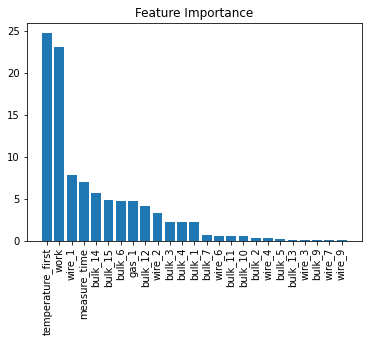

In [73]:
importance = model.feature_importances_

# Сортируем признаки по убыванию важности
sorted_idx = importance.argsort()[::-1]

# Строим график важности признаков
plt.bar(range(features.shape[1]), importance[sorted_idx])
plt.xticks(range(features.shape[1]), features.columns[sorted_idx], rotation=90)
plt.title("Feature Importance")
plt.show()

Наибольшая зависимость целевого признака от начальной температуры и работы

In [74]:
feature_importance_df = pd.DataFrame(importance, index=features.columns)
feature_importance_df.sort_values(0)

,0
wire_9,0.007136
wire_7,0.023859
bulk_9,0.035330
wire_3,0.078100
bulk_13,0.087536
bulk_5,0.162536
wire_4,0.290756
bulk_2,0.349588
bulk_10,0.539902
bulk_11,0.575497


Перенастроим модель, удалим признаки, которые практически не влияют на целевой признак, и сравним результат метрики

In [75]:
df_new = df.drop(columns=['bulk_7', 'wire_6', 'bulk_11','bulk_10', 'bulk_2',
                       'wire_4', 'bulk_5', 'bulk_13', 'wire_3', 'bulk_9', 'wire_7', 'wire_9'])


y = df_new['temperature_last']
X = df_new.drop('temperature_last', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                     test_size = 0.25, 
                                                     random_state=RND)

In [76]:
%%time

cbr_new = CatBoostRegressor(verbose=False, random_state=RND)

MAE_cbr_new = (cross_val_score(cbr_new,
                           X_train, 
                           y_train, 
                           cv=5, 
                           scoring='neg_mean_absolute_error').mean() * -1)

params_cbr_new = CatBoostRegressor(verbose=False,
                               random_state=RND).\
                               fit(X_train, y_train).\
                               get_all_params()

print('Параметры:', params_cbr_new)
print()

print('MAE CatBoostRegressor', MAE_cbr_new)
print()

Параметры: {'nan_mode': 'Min', 'eval_metric': 'RMSE', 'iterations': 1000, 'sampling_frequency': 'PerTree', 'leaf_estimation_method': 'Newton', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Plain', 'model_shrink_mode': 'Constant', 'feature_border_type': 'GreedyLogSum', 'bayesian_matrix_reg': 0.10000000149011612, 'force_unit_auto_pair_weights': False, 'l2_leaf_reg': 3, 'random_strength': 1, 'rsm': 1, 'boost_from_average': True, 'model_size_reg': 0.5, 'pool_metainfo_options': {'tags': {}}, 'subsample': 0.800000011920929, 'use_best_model': False, 'random_seed': 130323, 'depth': 6, 'posterior_sampling': False, 'border_count': 254, 'classes_count': 0, 'auto_class_weights': 'None', 'sparse_features_conflict_fraction': 0, 'leaf_estimation_backtracking': 'AnyImprovement', 'best_model_min_trees': 1, 'model_shrink_rate': 0, 'min_data_in_leaf': 1, 'loss_function': 'RMSE', 'learning_rate': 0.04470000043511391, 'score_function': 'Cosine', 'task_type': 'CPU', 'leaf_est

In [77]:
%%time

model_new = CatBoostRegressor(verbose=False)
model_new.set_params(**params_cbr_new)
model_new.fit(X_train, y_train)
y_predict = model_new.predict(X_test)
test_MAE_CBR_new = mean_absolute_error(y_predict, y_test)
print('MAE CatBoostRegressor_new on test', test_MAE_CBR_new)

MAE CatBoostRegressor_new on test 5.982412224971387
CPU times: user 2.63 s, sys: 146 ms, total: 2.78 s
Wall time: 3.65 s


Значение метрики МАЕ после удаления несущественных признаков практически не изменилось (5,96 и 5,98). Таким образом, мы можем исключить признаки, не влияющие на целевой признак, без потери качества предсказания 5-6 градусов 

**ВЫВОДЫ:**

- Использованы модели LinearRegression, RandomForestRegressor, CatBoostRegressor, LGBMRegressor, XGBRegressor;
- Наилучший результат показал CatBoostRegressor, наихудший результат у XGBRegressor. Однако, все значения метрики MAE находятся в диапазоне 5,83 - 6,58, то есть разница в предсказаниях разных моделей составляет 1 градус;
- Для тестирования выбран CatBoostRegressor, показавший наилучший результат. Значение метрики МАЕ на тестовой выборке составило 5,96;
- По результатам анализа значимости признаков видно, что наибольшее влияние на целевой признак с большим отрывом имеют начальная температура и работа; Далее, в меньшей степени, влияют добавки wire_1, bulk_14, bulk_15, bulk_14, bulk_6, время замера температуры и gas_1;
- Влияние остальных признаков очень незначительно. При перестройке модели, удалив признаки с важностью меньше 1, мы получили незначительное изменение метрики МАЕ с 5,96 до 5,98. Таким образом, можно исключить признаки, не влияющие на целевой признак, без потери качества предсказания 5-6 градусов.


### ОБЩИЙ ВЫВОД

Мы провели исследование с целью построить оптимальную модель для предсказания температуры сплава. 

Для решения этой задачи проделано следующее:
1. В процессе подготовки и первичного анализа данных были выявлены:
- пропуски в исходных данных по используемым добавкам и замерам температуры,
- очевидные выбросы в данных по рекативной мощности и температуре
- разное кол-во и значения партий (key)
2. При подготовке данных выбросы были удалены, пропуски заполнены нулями в том случае, если легирующие добавки не подавались.
3. Были вычислены дополнительные признаки - полная мощность, работа, время замера температуры и суммарное время нагрева, а также выделены начальная и конечная температуры, так как промежуточные значения для цели нашего исследования не важны. Полученные таблицы были объединены по номерам партий key, тем номерам партий, которые были во всех таблицах.
4. Была изучена корреляция признаков, в результате были выявлены сильная корреляция между двумя признаками (легириующими добавками), но не выявлено сильной зависимости каких-либо признаков с целевым - финальной температурой на этапе.
3. Для предсказаний мы выбрали модели:
- LinearRegression
- RandomForestRegressor
- CatBoostRegressor
- LGBMRegressor
- XGBRegressor  
И использовали масштабирование и кросс-валидацию.
4.	Наилучший результат MAE = 5,83 на обучающей выборке без сильнокоррелирующих признаков и МАЕ = 5,96 на тестовой выборке показала модель CatBoostRegressor. На целевой признак более всего влияют признаки начальная температура и работа. В меньшей степени влияют добавки wire_1, bulk_14, bulk_15, bulk_14, bulk_6, время замера температуры и gas_1.
5. Проверку на адекватность модель прошла, показав результат на 30% лучше.
6. Мы перенастроили модель, удалив из данных признаки, важность которых менее 1. Результат предсказания практически не изменился.  

Таким образом, для предсказания температуры сплава мы можем рекомендовать модель CatBoostRegressor, которая ошибается на 5,5-6 градусов, а также рекомендуем исключить признаки, практически не влияющие на финальную температуру на этапе (целевой признак).
Самым важным фактором, влияющим на целевой признак, является первая температура. Это значит, что управляя ею, мы сможем управлять энергозатратами.


# ОТЧЕТ

**1. Выполнение плана**  

В плане исследования было:

- Описание проекта, задачи
- Изучение и подготовка данных.
- Предобработка данных
- Подготовка данных:
    - Формирование итоговых датафреймов
    - Формирование целевого и остальных признаков
    - Формирование обучающих и тестовых выборок
- Обучение моделей
- Тестирование моделей
- Вывод. 

Все пункты плана выполнены, а также был добавлен пункт "Анализ значимости признаков"

**2. Трудности и решения**  

На этапе подготовки и первичного анализа были обнаружены пропуски данных, связанные с:  
•	вероятно неотлаженным сбором данных, что было принято  
•	неподачей легирующих добавок, что было решено заменой пропусков на 0 (нет добавки = 0)  
Также были обнаружены аномальные для данного процесса значения: отрицательное значение реактивной мощности -715.504924, значения температуры ниже 1400, что было принято как выброс и исключено из анализа, как ошибка.  
Кроме того, во всех датафреймах количество и перечень номеров партий (признак-столбец key) было различным, поэтому при объединении таблиц для анализа былии взяты только те партии, данные по которым были во всех датафреймах, чтобы анализ был точнее.

**3. Ключевые шаги в решении задачи**  

Ключевыми шагами в решении задачи стали блоки:  
•	Подготовка и анализ данных с последующей предобработкой, что обеспечило более качественный анализ и лучшую работу моделей  •	обучение моделей со сменой параметров и выбор лучшей по показателю MAE (Mean absolute error - средняя абсолютная ошибка, то есть показатель того, насколько градусов модель ошибается при расчете, соотвественно, чем меньше ошибка, тем лучше работает модель).  
Для поиска наилучшего показателя MAE были обучены 5 моделей, протестирована модель с наименьшей MAE, проведен анализ значимости признаков.

**4. Итоговая модель и её качество**  
Лучшей моделью из выбранных стал **CatBoostRegressor**, показавший наименьшее значение метрики MAE среди обученных.  
MAE CatBoostRegressor = 5.96, это означает, что модель ошибается на 5.96 градуса при прогнозировании. Стоит добавить, что показания всех выбранных моделей находятся в диапазоне 5,8-6,6. 
При этом легирующие добавки не снижают температуру, то есть при подаче этих материалов температура не падает, следовательно, не требуется дополнительная энергия на нагрев. При планировании использования добавок это стоит учитывать.

**Список признаков, используемых для лучшей модели**  
Для обучения моделей использовались признаки: 
- temperature_first (начальная температура)
- measure_time (время замера температуры)
- work (работа) 	
- bulk_1 ...	bulk_15 (данные о сыпучих материалах по объему)
- gas_1 (данные о продувке сплава газом)	
- wire_1 ... wire_9 (данные о проволочных материалах по объёму).  
Начальная и конечная температуры были выделены из данных о температуре путем аггрегации по минимуму и максимуму сгруппированных по номеру партии Key и measure_time (время замера) данных, с последующим объединением в таблицу по ключу measure_time. Все промежуточные значения температур в таблицу не попали.
Признаки данных об электродах:
- мощность (active_power, reactive_power, power)
- начало и окончание времени нагрева (start_heating,end_heating), вычисленный признак время нагрева (heating_time)  
ожидаемо показали очень высокую корреляцию, так как связаны между собой формулами:  
$$
S = \sqrt { P ^ 2+Q ^ 2 }
$$
$$
A = S*t
$$

было принято решение оставить в итоговой таблице только признак work (работа).  
также из итоговой таблицы перед разделением на обучающую и тестовую выборки удален признак key как неинформативный и обнаружена очень высокая прямая зависимость между wire_8 и bulk_9, было принято решение удалить один из признаков

**гиперпараметы лучшей модели**  
гиперпараметры модели CatBoostRegressor: 'nan_mode': 'Min', 'eval_metric': 'RMSE', 'iterations': 1000, 'sampling_frequency': 'PerTree', 'leaf_estimation_method': 'Newton', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Plain', 'model_shrink_mode': 'Constant', 'feature_border_type': 'GreedyLogSum', 'bayesian_matrix_reg': 0.10000000149011612, 'force_unit_auto_pair_weights': False, 'l2_leaf_reg': 3, 'random_strength': 1, 'rsm': 1, 'boost_from_average': True, 'model_size_reg': 0.5, 'pool_metainfo_options': {'tags': {}}, 'subsample': 0.800000011920929, 'use_best_model': False, 'random_seed': 130323, 'depth': 6, 'posterior_sampling': False, 'border_count': 254, 'classes_count': 0, 'auto_class_weights': 'None', 'sparse_features_conflict_fraction': 0, 'leaf_estimation_backtracking': 'AnyImprovement', 'best_model_min_trees': 1, 'model_shrink_rate': 0, 'min_data_in_leaf': 1, 'loss_function': 'RMSE', 'learning_rate': 0.04470000043511391, 'score_function': 'Cosine', 'task_type': 'CPU', 'leaf_estimation_iterations': 1, 'bootstrap_type': 'MVS', 'max_leaves': 64  
Random state 130323. Использована кросс-валидация, cv = 5

**Рекомендации для улучшения модели**  
 Для улучшения предсказаний рекомендуем при обучении не учитывать признаки, показавшие практически отсутствие влияния на целевой признак: 'bulk_7', 'wire_6', 'bulk_11','bulk_10', 'bulk_2', 'wire_4', 'bulk_5', 'bulk_13', 'wire_3', 'bulk_9', 'wire_7', 'wire_9'  
 Все эти данные содержат информацию о легитирующих добавках, которые используются редко и в малых объемах. Такие данные служат "балластом". Также по результатам анализа значимости признаков мы делаем вывод, что самым важным фактором, влияющим на целевой признак, является первая температура. Это значит, что управляя ею, мы сможем управлять энергозатратами.  
 В целях улучшения проекта стоит попробовать избавиться от данных, которые получены после замера конечной температуры. Также для оптимизации производственных расходов рекомендуется создать систему, которая определяла бы аномальные замеры.

Таким образом, цели и задачи проекта были выполнены.